In [30]:

import pandas as pd
df = pd.read_csv('bot_detection_data.csv')
df['Bot Label'].value_counts()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   User ID         50000 non-null  int64 
 1   Username        50000 non-null  object
 2   Tweet           50000 non-null  object
 3   Retweet Count   50000 non-null  int64 
 4   Mention Count   50000 non-null  int64 
 5   Follower Count  50000 non-null  int64 
 6   Verified        50000 non-null  bool  
 7   Bot Label       50000 non-null  int64 
 8   Location        50000 non-null  object
 9   Created At      50000 non-null  object
 10  Hashtags        41659 non-null  object
dtypes: bool(1), int64(5), object(5)
memory usage: 3.9+ MB


,User ID,Retweet Count,Mention Count,Follower Count,Bot Label
count,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000
mean,548890.680540,50.00560,2.513760,4988.602380,0.500360
std,259756.681425,29.18116,1.708563,2878.742898,0.500005
min,100025.000000,0.00000,0.000000,0.000000,0.000000
25%,323524.250000,25.00000,1.000000,2487.750000,0.000000
50%,548147.000000,50.00000,3.000000,4991.500000,1.000000
75%,772983.000000,75.00000,4.000000,7471.000000,1.000000
max,999995.000000,100.00000,5.000000,10000.000000,1.000000


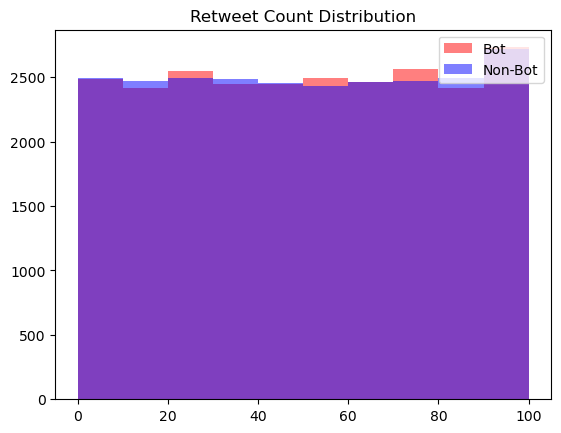

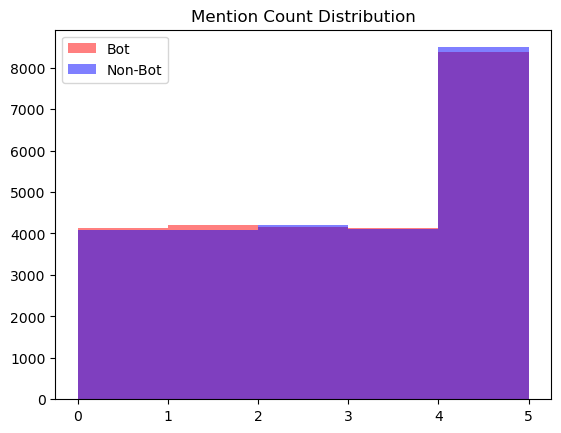

In [31]:

import matplotlib.pyplot as plt
import numpy as np

bot_tweets = df[df['Bot Label'] == 1]['Retweet Count']
non_bot_tweets = df[df['Bot Label'] == 0]['Retweet Count']
bin_edges = np.arange(0, 101, 10)
plt.hist(bot_tweets, bins=bin_edges, alpha=0.5, label='Bot', color='red')
plt.hist(non_bot_tweets, bins=bin_edges, alpha=0.5, label='Non-Bot', color='blue')
plt.title('Retweet Count Distribution')
plt.legend()
plt.show()

bins = range(0, 6)
bot_mentions = df[df['Bot Label'] == 1]['Mention Count']
non_bot_mentions = df[df['Bot Label'] == 0]['Mention Count']
plt.hist(bot_mentions, bins=bins, alpha=0.5, label='Bot', color='red')
plt.hist(non_bot_mentions, bins=bins, alpha=0.5, label='Non-Bot', color='blue')
plt.title('Mention Count Distribution')
plt.legend()
plt.show()


In [32]:
# NEW PART - Sample a manageable subset of users
df_sample = df.sample(n=5000, random_state=42).reset_index(drop=True)

# Recompute the TF-IDF matrix on the sample
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_sample['Tweet'])

In [33]:
df_sample['Bot Label'].value_counts()

Bot Label
0    2505
1    2495
Name: count, dtype: int64

In [34]:

# NEW PART
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

similarity_matrix = cosine_similarity(tfidf_matrix)
threshold = 0.3
G = nx.Graph()
for i in range(len(df_sample)):
    for j in range(i + 1, len(df_sample)):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])


In [6]:
!pip install node2vec

  Using cached node2vec-0.5.0-py3-none-any.whl.metadata (849 bytes)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached node2vec-0.5.0-py3-none-any.whl (7.2 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (83 kB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Un

In [44]:
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 1208 nodes and 764 edges


In [17]:

# NEW PART
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, p=1, q=1, workers=2)
model = node2vec.fit(window=10, min_count=1)
embedding = [model.wv[str(i)] for i in range(len(df_sample)) if str(i) in model.wv]
labels = df_sample.loc[[str(i) in model.wv for i in range(len(df_sample))], 'Bot Label']


Computing transition probabilities:   0%|          | 0/1208 [00:00<?, ?it/s]

In [28]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

X = np.array(embedding)
y = labels.to_numpy()

# Use cross_val_score to evaluate accuracy
clf = RandomForestClassifier()
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"5-fold accuracy: {np.mean(scores):.4f}")

# Get cross-validated predictions
y_pred = cross_val_predict(clf, X, y, cv=5)
print(classification_report(y, y_pred))

5-fold accuracy: 0.4901
              precision    recall  f1-score   support

           0       0.49      0.48      0.48       590
           1       0.51      0.51      0.51       618

    accuracy                           0.50      1208
   macro avg       0.50      0.50      0.50      1208
weighted avg       0.50      0.50      0.50      1208



<Axes: >

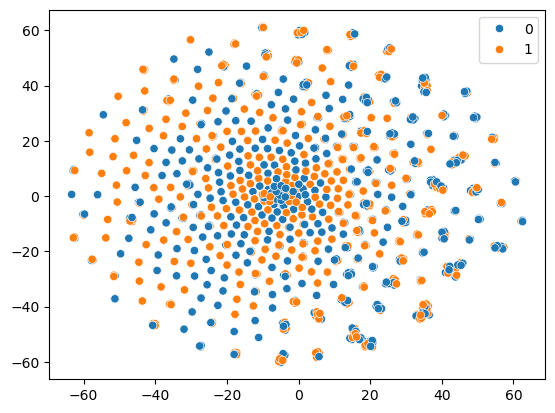

In [29]:

# NEW PART
from sklearn.manifold import TSNE
import seaborn as sns

X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y)


In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from node2vec import Node2Vec
import numpy as np

# Define parameter grid
param_grid = {
    'dimensions': [128, 256],
    'walk_length': [10, 30],
    'num_walks': [200, 300],
    'p': [0.25, 0.5, 1],
    'q': [0.25, 0.5, 1]
}

grid = ParameterGrid(param_grid)
best_score = 0
best_params = None

for params in grid:
    print(f"Trying params: {params}")
    try:
        node2vec = Node2Vec(
            G,
            dimensions=params['dimensions'],
            walk_length=params['walk_length'],
            num_walks=params['num_walks'],
            p=params['p'],
            q=params['q'],
            workers=2,
            seed=42,
            quiet=True
        )
        model = node2vec.fit(window=10, min_count=1)
        
        # Align embedding and labels
        embedding = [model.wv[str(i)] for i in range(len(df_sample)) if str(i) in model.wv]
        labels = df_sample.loc[[str(i) in model.wv for i in range(len(df_sample))], 'Bot Label']

        X = np.array(embedding)
        y = labels.to_numpy()

        clf = LogisticRegression(max_iter=1000)
        scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
        mean_score = np.mean(scores)

        print(f"F1 macro score: {mean_score:.4f}")

        if mean_score > best_score:
            best_score = mean_score
            best_params = params
    except Exception as e:
        print(f"Failed for params {params}: {e}")

print(f"\nBest F1 score: {best_score}")
print(f"Best parameters: {best_params}")

Trying params: {'dimensions': 128, 'num_walks': 200, 'p': 0.25, 'q': 0.25, 'walk_length': 10}
F1 macro score: 0.4700
Trying params: {'dimensions': 128, 'num_walks': 200, 'p': 0.25, 'q': 0.25, 'walk_length': 30}
F1 macro score: 0.5075
Trying params: {'dimensions': 128, 'num_walks': 200, 'p': 0.25, 'q': 0.5, 'walk_length': 10}
F1 macro score: 0.4917
Trying params: {'dimensions': 128, 'num_walks': 200, 'p': 0.25, 'q': 0.5, 'walk_length': 30}
F1 macro score: 0.4786
Trying params: {'dimensions': 128, 'num_walks': 200, 'p': 0.25, 'q': 1, 'walk_length': 10}
F1 macro score: 0.4921
Trying params: {'dimensions': 128, 'num_walks': 200, 'p': 0.25, 'q': 1, 'walk_length': 30}
F1 macro score: 0.4781
Trying params: {'dimensions': 128, 'num_walks': 200, 'p': 0.5, 'q': 0.25, 'walk_length': 10}
F1 macro score: 0.4926
Trying params: {'dimensions': 128, 'num_walks': 200, 'p': 0.5, 'q': 0.25, 'walk_length': 30}
F1 macro score: 0.4985
Trying params: {'dimensions': 128, 'num_walks': 200, 'p': 0.5, 'q': 0.5, '

In [46]:
print("Best F1 score:", best_score)
print("Best parameters:", best_params)

Best F1 score: 0.5324734807416149
Best parameters: {'dimensions': 256, 'num_walks': 200, 'p': 0.25, 'q': 1, 'walk_length': 30}


In [47]:

# NEW PART
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=256, walk_length=30, num_walks=200, p=1, q=0.25, workers=2)
model = node2vec.fit(window=10, min_count=1)
embedding = [model.wv[str(i)] for i in range(len(df_sample)) if str(i) in model.wv]
labels = df_sample.loc[[str(i) in model.wv for i in range(len(df_sample))], 'Bot Label']


Computing transition probabilities:   0%|          | 0/1208 [00:00<?, ?it/s]

In [48]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

X = np.array(embedding)
y = labels.to_numpy()

# Use cross_val_score to evaluate accuracy
clf = RandomForestClassifier()
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"5-fold accuracy: {np.mean(scores):.4f}")

# Get cross-validated predictions
y_pred = cross_val_predict(clf, X, y, cv=5)
print(classification_report(y, y_pred))

5-fold accuracy: 0.4851
              precision    recall  f1-score   support

           0       0.47      0.47      0.47       590
           1       0.50      0.50      0.50       618

    accuracy                           0.49      1208
   macro avg       0.49      0.49      0.49      1208
weighted avg       0.49      0.49      0.49      1208



<Axes: >

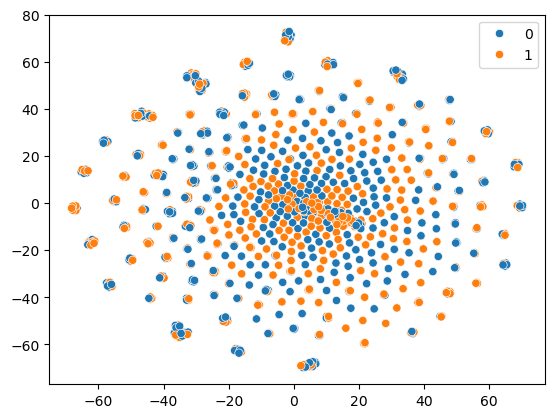

In [49]:

# NEW PART
from sklearn.manifold import TSNE
import seaborn as sns

X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y)


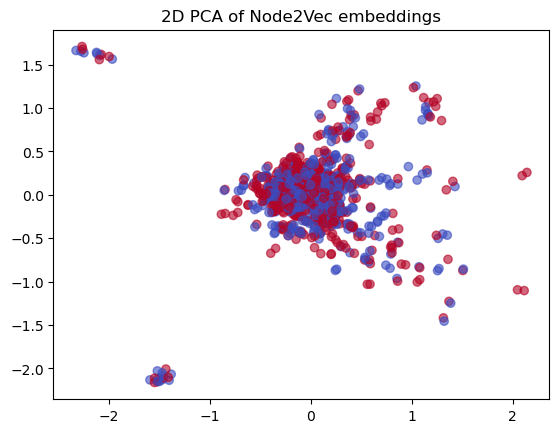

In [50]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(embedding)

plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='coolwarm', alpha=0.6)
plt.title("2D PCA of Node2Vec embeddings")
plt.show()

In [54]:
from sklearn.neighbors import kneighbors_graph

# Build kNN graph from TF-IDF (each node connects to 10 nearest neighbors)
adjacency = kneighbors_graph(tfidf_matrix, n_neighbors=10, mode='connectivity', include_self=False)
G = nx.from_scipy_sparse_array(adjacency)

node2vec = Node2Vec(G, dimensions=128, walk_length=40, num_walks=300, p=0.5, q=2, workers=1)
model = node2vec.fit(window=10, min_count=1)

indices = [i for i in range(len(df_sample)) if str(i) in model.wv]
embedding = [model.wv[str(i)] for i in indices]
labels = df_sample.loc[indices, 'Bot Label'].to_numpy()

clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
scores = cross_val_score(clf, embedding, labels, cv=5, scoring='accuracy')
print(f"5-fold accuracy: {np.mean(scores):.4f}")

y_pred = cross_val_predict(clf, embedding, labels, cv=5)
print(classification_report(labels, y_pred))

Computing transition probabilities:   0%|          | 0/5000 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 300/300 [04:12<00:00,  1.19it/s]


5-fold accuracy: 0.5048
              precision    recall  f1-score   support

           0       0.51      0.55      0.53      2505
           1       0.50      0.46      0.48      2495

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.50      0.50      0.50      5000

